In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import glob
import os
from collections import defaultdict

In [3]:
data_dir = os.path.expanduser("~/Documents/Senior/Fall/Clinic/Data Cleaner/tarsalis_data_clean")
os.chdir(data_dir)
filenames = glob.glob('*.csv')
dataframes = [pd.read_csv(f) for f in filenames]

In [4]:
changepoints = []
for df in dataframes:
    x = df["pre_rect"].values
    cp = []
    labels = df["labels"].values
    for i in range(len(labels)):
        if i == 0:
            cp.append(i)
        elif i > 0:
            if labels[i] != labels[i - 1]:
                cp.append(i)
        elif i == len(labels) - 1:
            cp.append(i)
    changepoints.append(cp)

In [17]:
def probe_splitter(recording, window = 500, threshold = 0.1,
                   min_probe_length = 1500, np_pad = 500):
    """
    Input: recording: A pre-rectified mosquito recording as an 1-D nupmy 
             array. Pre-rectified recordings are necessary as baseline is 
             not 0 in post-rectified recordings.
           window: Before NP regions can be identified, a rolling
             average filter is applied to remove noise in the NP regions.
             window is the size of this filter in samples.
           threshold: The maximum value of an NP sample.
           min_probe_length: The minimum acceptable length of a probe in
             samples.
           np_pad: the number of NP samples before and after each probe to
             include. Note that high values might result in overlapping with
             the next probe.
    Output: A list of (start sample, end sample) tuples for each probe. By 
            default contains about 5 seconds of NPs at the beginning and end 
            of each probe. We say "about" because this splitting is done
            in an unsupervised manner, although it is largely pretty good.
    """
    
    smoothed = np.convolve(recording, np.ones(window), "same")/window
    is_NP = smoothed < threshold # NP is where the signal is close to 0
    
    # Find starts and ends, combine into tuple
    find_sequence = lambda l, seq : [i for i in range(len(l)) if l[i:i+len(seq)] == seq]
    is_NP_list = list(is_NP)
    probe_starts = find_sequence(is_NP_list, [True, False])
    probe_ends = find_sequence(is_NP_list, [False, True])
    probes = zip(probe_starts, probe_ends)
    
    # Remove probes that are too short and pad
    probes = [(max(0, start - np_pad), end + np_pad) for start, end in probes if end - start > min_probe_length]
    
    return probes

In [18]:
prbs = probe_splitter(dataframes[0]["pre_rect"].values)
prbs = [probe_splitter(df["pre_rect"].values) for df in dataframes]

In [19]:
prbs

[[(14634, 24288),
  (27349, 36615),
  (38826, 46353),
  (48121, 56372),
  (57458, 82686)],
 [(16361, 43775), (44933, 98512)],
 [(8033, 56610)],
 [(3787, 114385)],
 [(3881, 37771)],
 [(33304, 37602), (40020, 42555)],
 [(5781, 10216), (34234, 38379)],
 [(6071, 70107)],
 [(6109, 62900)],
 [(54956, 167628)],
 [(15728, 78224)],
 [(2371, 16164), (16066, 50087)],
 [(9645, 70783)],
 [(8722, 61124),
  (60892, 72088),
  (71984, 94445),
  (94023, 97590),
  (98217, 146634)],
 [(9683, 76701)],
 [(3205, 36193)],
 [(1693, 12393), (12606, 22215), (24051, 48659)],
 [(0, 5018), (40150, 115290)],
 [(9400, 34490)],
 [(14325, 56107)],
 [(45681, 80616)],
 [(1480, 23394), (32623, 63272)],
 [(51870, 86585)],
 [(54910, 59631), (60567, 101969)],
 [(3431, 15327), (22855, 145994)],
 [(24422, 30820), (30776, 35438), (44885, 61635), (61557, 170529)],
 [(24180, 50382)],
 [(17146, 62821)],
 [(18694, 43798), (50096, 103683)],
 [(15036, 72312)],
 [(9342, 98874)],
 [(46593, 49261), (48734, 100726)],
 [(31199, 136305)],


In [27]:
probes = []
for df, probe_times in zip(dataframes, prbs):
    for start, end in probe_times:
        probes.append(df["post_rect"][start:end].values)

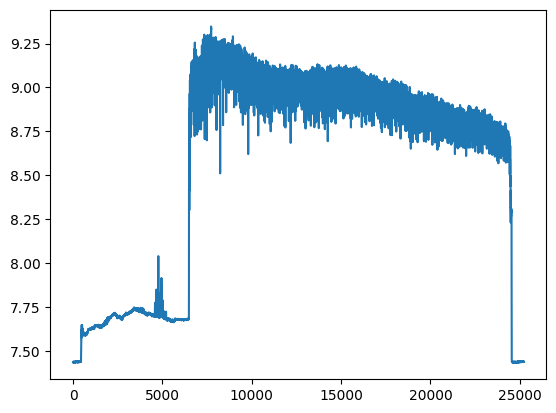

In [83]:
%matplotlib inline
plt.plot(probes[4])

In [61]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.window_size import dominant_fourier_frequency, highest_autocorrelation, suss

In [79]:
print(f"SuSS: {suss(probes[0])}")

SuSS: 146


In [69]:
import time

In [88]:
start = time.time()
clasp = BinaryClaSPSegmentation(threshold = 10e-1)
cps = clasp.fit_predict(probes[4])
end = time.time()
print(end - start)

16.223190546035767


array([<Axes: >, <Axes: xlabel='split point', ylabel='ClaSP Score'>],
      dtype=object)

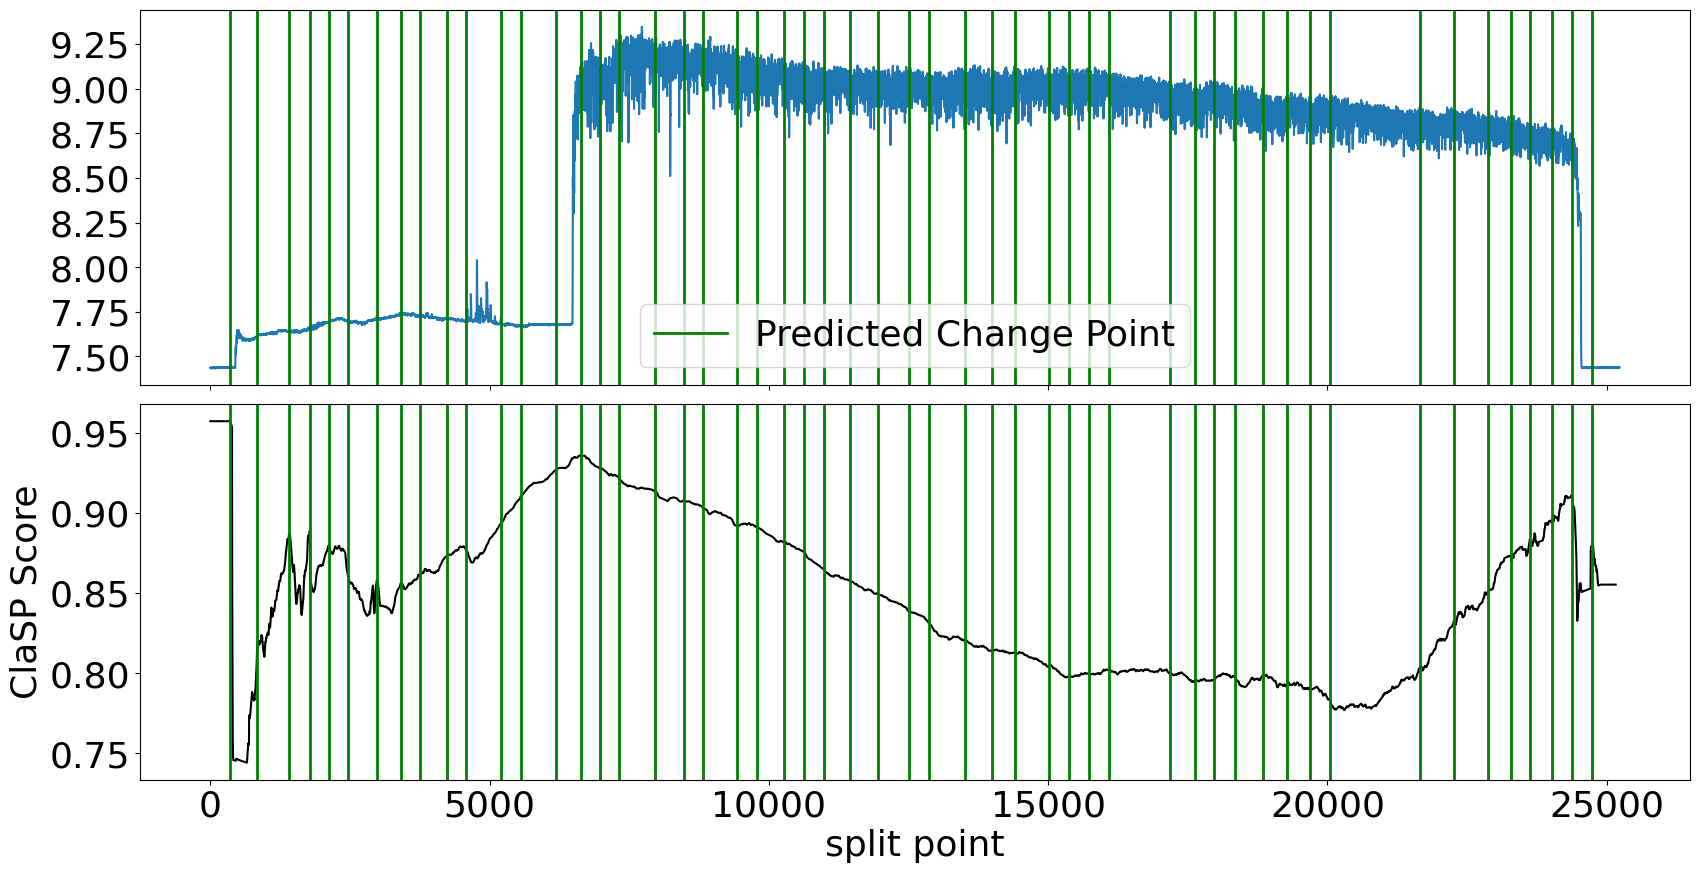

In [89]:
clasp.plot()

In [54]:
plt.plot(np.arange(len(time_series)) / 100, time_series)
plt.vlines(np.array(changepoints[2]) / 100, ymin = min(time_series), ymax = max(time_series), color = "black")
plt.vlines(cps / 100, ymin = min(time_series), ymax = max(time_series), color = "red")
plt.xlabel("Time (s)")
#cps = [c / 100 for c in changepoints[2] if c in range(7000, 56000)]
#plt.vlines(cps, ymin = 0, ymax = 0.5, color = "red")

Text(0.5, 0, 'Time (s)')

In [62]:
from scipy.signal import find_peaks


array([ 1065,  1514,  2765,  4400,  4979,  5807, 24482, 25805, 35444,
       46127, 48646], dtype=int64)

In [84]:
peaks = find_peaks(ts[cps[2]: cps[3]], width = 3)[0]

In [85]:
plt.plot(ts[cps[2]: cps[3]])
plt.scatter(peaks, ts[cps[2]: cps[3]][peaks])

In [86]:
len(peaks) / (len(ts[cps[2]: cps[3]]) / 100)

2.9969418960244645